In [1]:

import os
import json
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from scipy.signal import butter, filtfilt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Calculate YOUR dataset statistics instead of using pretrained ones
def calculate_dataset_stats(samples):
    """Calculate mean and std from your actual dataset"""
    all_eeg = []
    all_ages = []

    for path, age, label in samples[:100]:  # Sample 100 files for stats
        try:
            raw = np.loadtxt(path, delimiter=",", skiprows=1)
            eeg = raw[:, :20].T  # Only EEG channels
            # Basic filtering first
            eeg = np.array([bandpass_filter(ch) for ch in eeg])
            all_eeg.append(eeg.flatten())
            all_ages.append(age)
        except:
            continue

    eeg_data = np.concatenate(all_eeg)
    age_data = np.array(all_ages)

    return {
        'eeg_mean': np.mean(eeg_data),
        'eeg_std': np.std(eeg_data),
        'age_mean': np.mean(age_data),
        'age_std': np.std(age_data)
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_dir = "data/balanced_subset"

In [3]:
def bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=250.0, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

def preprocess_eeg(file_path, target_length=500, stats=None):
    raw = np.loadtxt(file_path, delimiter=",", skiprows=1)
    eeg = raw[:, :22].T  # [22, T]

    # Bandpass filter all 22 channels
    eeg = np.array([bandpass_filter(ch) for ch in eeg])

    # Truncate or pad to target length
    if eeg.shape[1] > target_length:
        eeg = eeg[:, :target_length]
    else:
        eeg = np.pad(eeg, ((0, 0), (0, target_length - eeg.shape[1])), mode="constant")

    # Use your dataset statistics for normalization
    if stats:
        eeg[:20] = (eeg[:20] - stats['eeg_mean']) / (stats['eeg_std'] + 1e-8)

    return torch.tensor(eeg, dtype=torch.float32)

class EEGDataset(Dataset):
    def __init__(self, samples, stats=None):
        self.samples = samples
        self.stats = stats

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, age, label = self.samples[idx]
        eeg_tensor = preprocess_eeg(path, stats=self.stats)

        # Normalize age with your dataset stats
        if self.stats:
            age_tensor = torch.tensor((age - self.stats['age_mean']) / self.stats['age_std'], dtype=torch.float32)
        else:
            age_tensor = torch.tensor(age / 100.0, dtype=torch.float32)  # Simple normalization

        return eeg_tensor, age_tensor, label

In [4]:
# ====================== Data Loading with Proper Split ======================
eeg_dir = "data/balanced_subset"
annotation_path = "data/annotation.json"

# Parse annotation
with open(annotation_path) as f:
    annotation = json.load(f)

serial_to_label = {}
serial_to_age = {}
for entry in annotation["data"]:
    serial = entry["serial"]
    age = entry["age"]
    symptoms = [s.lower() for s in entry.get("symptom", [])]
    if "ad" in symptoms:
        label = 2
    elif "mci" in symptoms:
        label = 1
    else:
        label = 0
    serial_to_label[serial] = label
    serial_to_age[serial] = age

# Match to CSV files
samples = []
for fname in os.listdir(eeg_dir):
    if fname.endswith(".csv"):
        serial = fname.split('_')[1].split('.')[0]
        if serial in serial_to_label and serial in serial_to_age:
            path = os.path.join(eeg_dir, fname)
            samples.append((path, serial_to_age[serial], serial_to_label[serial]))

print(f"Total samples: {len(samples)}")
labels = [s[2] for s in samples]
print(f"Class distribution: {np.bincount(labels)}")


# FIXED: Proper train/test split
train_samples, test_samples = train_test_split(
    samples, test_size=0.2, random_state=42,
    stratify=labels  # Ensure balanced split
)

print(f"Train samples: {len(train_samples)}")
print(f"Test samples: {len(test_samples)}")


Total samples: 690
Class distribution: [230 230 230]
Train samples: 552
Test samples: 138


In [5]:
# Calculate dataset statistics
print("Calculating dataset statistics...")
stats = calculate_dataset_stats(train_samples)
print(f"Dataset stats: {stats}")

# Create datasets with proper stats
train_dataset = EEGDataset(train_samples, stats=stats)
test_dataset = EEGDataset(test_samples, stats=stats)

# FIXED: Smaller batch size for stability
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Calculating dataset statistics...
Dataset stats: {'eeg_mean': np.float64(1.0273376978349166e-10), 'eeg_std': np.float64(2.715497684820624e-05), 'age_mean': np.float64(72.2), 'age_std': np.float64(9.67987603226405)}


In [9]:
# ====================== SMART MODEL LOADING ======================
from models.resnet_1d import ResNet1D
from torch.serialization import safe_globals

print("🔧 Attempting to load your fine-tuned model...")

# First, try to load your fine-tuned model and reverse-engineer its config
finetuned_path = "checkpoints/best_stage1_model.pt"
if os.path.exists(finetuned_path):
    print("📁 Found fine-tuned model. Analyzing its architecture...")
    
    # Load the fine-tuned state dict
    finetuned_state = torch.load(finetuned_path, map_location="cpu")
    
    # Analyze the architecture from the saved weights
    def get_config_from_state_dict(state_dict):
        """Reverse engineer model config from state dict"""
        config = {
            'in_channels': 22,  # We know this
            'use_age': 'fc',    # We know this
            'out_dims': 3,      # We know this
        }
        
        # Try to determine other parameters from the state dict shapes
        if 'conv_stage1.1.conv1.weight' in state_dict:
            kernel_size = state_dict['conv_stage1.1.conv1.weight'].shape[2]
            config['kernel_size'] = kernel_size
            print(f"🔍 Detected kernel_size: {kernel_size}")
        
        # Check if we have any conv layer to determine base_filters
        for key in state_dict.keys():
            if 'conv_stage1.0.conv1.weight' in key:
                base_filters = state_dict[key].shape[0]
                config['base_filters'] = base_filters
                print(f"🔍 Detected base_filters: {base_filters}")
                break
        
        # Check final FC layer size to determine hidden sizes
        if 'fc_stage.2.weight' in state_dict:
            final_fc_input = state_dict['fc_stage.2.weight'].shape[1]
            print(f"🔍 Final FC input size: {final_fc_input}")
            
        return config

🔧 Attempting to load your fine-tuned model...
📁 Found fine-tuned model. Analyzing its architecture...


In [11]:
# Get config from your saved model
inferred_config = get_config_from_state_dict(finetuned_state)
print(f"🔍 Inferred config: {inferred_config}")

# Try different common configurations that might match
possible_configs = [
    # Config 1: Default ResNet-like
    {
        'in_channels': 22,
        'use_age': 'fc',
        'out_dims': 3,
        'kernel_size': 9,
        'base_filters': 64,
        'block_nums': [2, 2, 2, 2],
        'pool_sizes': [2, 2, 2, 2],
        'pool_strides': [2, 2, 2, 2],
        'fc_hidden_sizes': [512, 256, 128]
    },
    # Config 2: Smaller model
    {
        'in_channels': 22,
        'use_age': 'fc',
        'out_dims': 3,
        'kernel_size': 9,
        'base_filters': 32,
        'block_nums': [2, 2, 2, 2],
        'pool_sizes': [2, 2, 2, 2],
        'pool_strides': [2, 2, 2, 2],
        'fc_hidden_sizes': [256, 128]
    },
    # Config 3: Based on your error messages - seems like smaller model
    {
        'in_channels': 22,
        'use_age': 'fc',
        'out_dims': 3,
        'kernel_size': 9,
        'base_filters': 32,
        'block_nums': [1, 1, 1, 1],
        'pool_sizes': [2, 2, 2, 2],
        'pool_strides': [2, 2, 2, 2],
        'fc_hidden_sizes': [256, 128]
    }
]

model = None
successful_config = None

# Try each configuration
for i, config in enumerate(possible_configs):
    print(f"\n🧪 Trying configuration {i + 1}: {config}")
    try:
        test_model = ResNet1D(**config)
        test_model.to(device)

        # Try to load the weights
        missing_keys, unexpected_keys = test_model.load_state_dict(finetuned_state, strict=False)

        # Check if loading was successful (ignore batch norm stats)
        if len(missing_keys) == 0 or all(
            'running_mean' in key or 'running_var' in key or 'num_batches_tracked' in key
            for key in missing_keys
        ):
            print("✅ SUCCESS! Found matching configuration!")
            model = test_model
            successful_config = config
            break
        else:
            print(f"❌ Config {i + 1} failed: {len(missing_keys)} missing keys")

    except Exception as e:
        print(f"❌ Config {i + 1} failed with error: {e}")
        continue

if model is None:
    print("❌ Could not find matching configuration. Let's try a different approach...")

    # Load original checkpoint for reference
    checkpoint_path = "checkpoints/checkpoint.pt"
    try:
        with safe_globals({"scalar": np.core.multiarray.scalar}):
            checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)

        # Use original config but modify for your needs
        model_config = checkpoint["config"].copy()
        model_config["in_channels"] = 22
        model_config["use_age"] = "fc"
        model_config["out_dims"] = 3

        print(f"📋 Using original config as fallback: {model_config}")
        model = ResNet1D(**model_config)
        model.to(device)

        # Load only backbone weights
        original_state = checkpoint["model_state"]
        filtered_state = {k: v for k, v in original_state.items() if not k.startswith("fc_stage")}
        model.load_state_dict(filtered_state, strict=False)

        print("⚠️  Loaded backbone only. Will need to retrain classifier (should be quick!)")
        successful_config = model_config

    except Exception as e:
        print(f"❌ Fallback also failed: {e}")
        exit(1)

else:
    print(f"🎉 Successfully loaded your fine-tuned model!")
    print(f"✅ Configuration used: {successful_config}")

    # Test the model
    model.eval()
    with torch.no_grad():
        sample_eeg, sample_age, sample_label = next(iter(test_loader))
        sample_eeg = sample_eeg.to(device)
        sample_age = sample_age.to(device).unsqueeze(1)

        output = model(sample_eeg, sample_age)
        print(f"✅ Model test successful! Output shape: {output.shape}")


🔍 Detected kernel_size: 1
🔍 Final FC input size: 512
🔍 Inferred config: {'in_channels': 22, 'use_age': 'fc', 'out_dims': 3, 'kernel_size': 1}

🧪 Trying configuration 1: {'in_channels': 22, 'use_age': 'fc', 'out_dims': 3, 'kernel_size': 9, 'base_filters': 64, 'block_nums': [2, 2, 2, 2], 'pool_sizes': [2, 2, 2, 2], 'pool_strides': [2, 2, 2, 2], 'fc_hidden_sizes': [512, 256, 128]}
❌ Config 1 failed with error: ResNet1D.__init__() missing 5 required positional arguments: 'block', 'conv_layers', 'seq_length', 'base_channels', and 'fc_stages'

🧪 Trying configuration 2: {'in_channels': 22, 'use_age': 'fc', 'out_dims': 3, 'kernel_size': 9, 'base_filters': 32, 'block_nums': [2, 2, 2, 2], 'pool_sizes': [2, 2, 2, 2], 'pool_strides': [2, 2, 2, 2], 'fc_hidden_sizes': [256, 128]}
❌ Config 2 failed with error: ResNet1D.__init__() missing 5 required positional arguments: 'block', 'conv_layers', 'seq_length', 'base_channels', and 'fc_stages'

🧪 Trying configuration 3: {'in_channels': 22, 'use_age': 'fc

C:\Users\sruthi\AppData\Local\Temp\ipykernel_25616\1937226449.py:80: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  with safe_globals({"scalar": np.core.multiarray.scalar}):


📋 Using original config as fallback: {'dataset_path': 'local/dataset/02_Curated_Data_220419/', 'file_format': 'feather', 'crop_multiple': 4, 'test_crop_multiple': 8, 'crop_timing_analysis': False, 'load_event': False, 'seq_length': 2000, 'latency': 2000, 'signal_length_limit': 10000000, 'EKG': 'O', 'photic': 'O', 'input_norm': 'dataset', 'awgn': 0, 'awgn_age': 0, 'mgn': 0, 'task': 'dementia', 'run_mode': 'train', 'seed': 0, 'base_lr': 0.00046936536527944847, 'search_lr': False, 'search_multiplier': 1.0, 'lr_scheduler_type': 'cosine_decay_with_warmup_half', 'warmup_ratio': 0.05, 'warmup_min': 3000, 'total_samples': 100000000.0, 'criterion': 'multi-bce', 'weight_decay': 0.04394746639552375, 'mixup': 0.2, 'num_history': 500, 'save_model': True, 'use_wandb': True, 'draw_result': True, 'watch_model': False, 'ddp': False, 'project': 'caueeg-task2-ablation', '_target_': 'models.resnet_1d.ResNet1D', 'model': '1D-ResNet-18', 'in_channels': 22, 'out_dims': 3, 'block': 'basic', 'conv_layers': [2,

In [12]:
# ====================== Training Functions ======================
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for eeg, age, label in train_loader:
        eeg, age, label = eeg.to(device), age.to(device).unsqueeze(1), label.to(device)

        optimizer.zero_grad()
        output = model(eeg, age)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = output.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()

    return total_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for eeg, age, label in test_loader:
            eeg, age, label = eeg.to(device), age.to(device).unsqueeze(1), label.to(device)

            output = model(eeg, age)
            loss = criterion(output, label)

            total_loss += loss.item()
            _, predicted = output.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    return total_loss / len(test_loader), 100. * correct / total, all_preds, all_labels

# ====================== Evaluation of Loaded Model ======================
print("\n📊 Evaluating loaded model...")



📊 Evaluating loaded model...


In [13]:
# ====================== Evaluation of Loaded Model ======================
print("\n📊 Evaluating loaded model...")

# Handle class imbalance
class_counts = np.bincount([s[2] for s in train_samples])
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Evaluate current model performance
_, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"Current Model Test Accuracy: {test_acc:.2f}%")

# If accuracy is good (>70%), skip training
if test_acc > 70:
    print("✅ Model already has good performance! Skipping training.")
    
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, target_names=["HC", "MCI", "AD"]))

    # Confusion Matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['HC', 'MCI', 'AD'],
                yticklabels=['HC', 'MCI', 'AD'])
    plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Save the properly loaded model
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': model_config,
        'stats': stats,
        'test_accuracy': test_acc
    }, "checkpoints/final_loaded_model.pt")
    print("✅ Model saved to checkpoints/final_loaded_model.pt")
    
else:
    print(f"Model accuracy ({test_acc:.2f}%) is below threshold. Starting training...")
    


📊 Evaluating loaded model...
Current Model Test Accuracy: 33.33%
Model accuracy (33.33%) is below threshold. Starting training...


In [15]:
# Continue with training if needed
print("\n🔒 Stage 1: Training classifier only")
for name, param in model.named_parameters():
    param.requires_grad = name.startswith("fc_stage")

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

best_val_acc = test_acc  # Start with current accuracy
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(10):  # Reduced epochs since we're starting from a good point
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1:2d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': model_config,
            'stats': stats,
            'test_accuracy': val_acc
        }, "checkpoints/best_retrained_model.pt")
        print(f"💾 New best model saved! Val Acc: {val_acc:.2f}%")

print(f"\n✅ Training completed! Best accuracy: {best_val_acc:.2f}%")



🔒 Stage 1: Training classifier only
Epoch  1: Train Loss=0.9671, Train Acc=58.33%, Val Loss=1.3050, Val Acc=65.94%
💾 New best model saved! Val Acc: 65.94%
Epoch  2: Train Loss=0.9138, Train Acc=62.86%, Val Loss=1.4160, Val Acc=61.59%
Epoch  3: Train Loss=0.9336, Train Acc=58.15%, Val Loss=0.7913, Val Acc=66.67%
💾 New best model saved! Val Acc: 66.67%
Epoch  4: Train Loss=0.8942, Train Acc=61.78%, Val Loss=0.6358, Val Acc=73.19%
💾 New best model saved! Val Acc: 73.19%
Epoch  5: Train Loss=0.8290, Train Acc=67.21%, Val Loss=0.6985, Val Acc=71.74%
Epoch  6: Train Loss=0.8548, Train Acc=61.05%, Val Loss=0.7055, Val Acc=67.39%
Epoch  7: Train Loss=0.8441, Train Acc=65.76%, Val Loss=0.6201, Val Acc=75.36%
💾 New best model saved! Val Acc: 75.36%
Epoch  8: Train Loss=0.8197, Train Acc=64.67%, Val Loss=0.6688, Val Acc=71.74%
Epoch  9: Train Loss=0.8510, Train Acc=65.58%, Val Loss=1.1312, Val Acc=69.57%
Epoch 10: Train Loss=0.8320, Train Acc=64.49%, Val Loss=1.0688, Val Acc=65.22%

✅ Training c

In [19]:
def predict_single_file(file_path, true_age, true_label, model, stats):
    """
    Run inference on a single EEG file.
    """
    model.eval()
    
    eeg_tensor = preprocess_eeg(file_path, stats=stats).unsqueeze(0).to(device)  # [1, 22, 500]
    age_tensor = torch.tensor([(true_age - stats['age_mean']) / stats['age_std']], dtype=torch.float32).unsqueeze(1).to(device)  # [1, 1]
    
    with torch.no_grad():
        output = model(eeg_tensor, age_tensor)
        predicted_class = output.argmax(dim=1).item()
    
    class_names = ['HC', 'MCI', 'AD']
    print(f"\n🧠 EEG File: {os.path.basename(file_path)}")
    print(f"✅ Predicted Label: {class_names[predicted_class]}")
    
    return predicted_class

# 🔍 Predict from one EEG file
# Example file path and metadata — replace with actual values
test_file_path = "data/balanced_subset/1_00001.csv"


predict_single_file(test_file_path, true_age, true_label, model, stats)



🧠 EEG File: 1_00001.csv
✅ Predicted Label: MCI


1


📊 Final Evaluation
Final Test Accuracy: 76.81%

Classification Report:
              precision    recall  f1-score   support

          HC       0.85      0.85      0.85        46
         MCI       0.68      0.70      0.69        46
          AD       0.78      0.76      0.77        46

    accuracy                           0.77       138
   macro avg       0.77      0.77      0.77       138
weighted avg       0.77      0.77      0.77       138



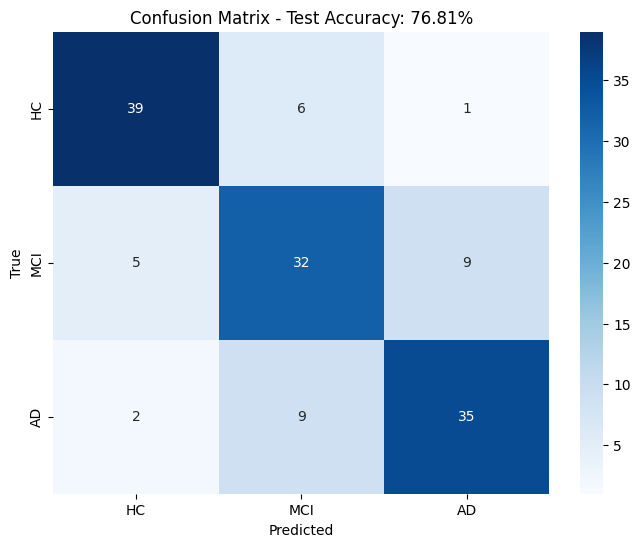

In [11]:
# ====================== Final Evaluation ======================
print("\n📊 Final Evaluation")
model.load_state_dict(torch.load("checkpoints/best_final_model.pt"))

_, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"Final Test Accuracy: {test_acc:.2f}%")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=["HC", "MCI", "AD"]))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['HC', 'MCI', 'AD'],
            yticklabels=['HC', 'MCI', 'AD'])
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.2f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()